This notebook analyzes cases deemed medically qualified that went to the PRB for a vote from Jan. 1, 2022 to Jun. 16, 2023.

In [2]:
import pandas as pd
import re

In [175]:
# load source data copied down from google sheets

# load grants
grants = pd.read_csv('source/IPRB MR voting tracker_grants_8.15.23.csv',skiprows=3)

# load denials
den = pd.read_csv('/home/aqin/Documents/stories/medical-release/source/IPRB MR voting tracker_denials_8.15.23.csv', skiprows=3)

In [176]:
grants.tail()

,MR #,Last Name,First Name,IDOC #,Date granted,Vote,Members
47,MR0133,Stutz,Darek,B16438,6/30/2023,(3-0),"For: Heaton, Miller, Tupy"
48,MR0141,Chavez,Raul,R01622,7/7/2023,(3-0),"For: Goff, Shoffner, Terrones"
49,MR0142,Milons,Chavez,N83814,7/21/2023,(3-0),"For: Bohland, Coates, Tupy"
50,MR0150,Dean,John,M09665,7/28/2023,(3-0),"For: Coates, Heaton, Shoffner"
51,MR0161,Pritcherd,Charles,B30468,8/10/2023,(3-0),"For: Bohland, shelton, Terrones"


In [177]:
den.head()

,MR #,Last Name,First Name,IDOC #,Date denied,Vote,Members
0,MR0002,Burke,Dwayne,N80531,3/16/2022,(3-0),"For: Bohland, Miller, Tupy"
1,MR0013,Miller,Joseph,A82547,4/18/2022,(3-0),"For: Crigler, Bohland Miller"
2,MR0014,Perkins,Ernest,N82771,4/18/2022,(3-0),"For: Crigler, Bohland Miller"
3,MR0015,Wiggins,Malcolm,N04370,4/18/2022,(3-0),"For: Crigler, Bohland Miller"
4,MR0011,Rhoiney,Eugene,A15243,4/18/2022,(3-0),"For: Crigler, Bohland Miller"


## Create and clean a cases dataframe

In [178]:
# clean data types for grants and denials

# format members and votes as strings
grants['Members'] = grants['Members'].astype(str)
den['Members'] = den['Members'].astype(str)

In [179]:
# clean up and reformat Members col int members_for and members_against cols for grants and denials dfs separately 
# members_for = voted to grant release
# members_against = voted against granting release

# create functions to grab for and against members from the Members 
def get_members_for(row):
    split_list = re.split('Against', row[6])
    members_for = split_list[0].replace('For: ', '')
    return members_for

def get_members_against(row):
    split_list = re.split('Against', row[6])
    if len(split_list) == 2:
        return split_list[1]
    else:
        return ''

# apply these functions to cases in two new cols: members_for and members_against
# it's reversed for grants and den
grants['members_for'] = grants.apply(get_members_for, axis=1)
grants['members_against'] = grants.apply(get_members_against, axis=1)

den['members_for'] = den.apply(get_members_against, axis=1)
den['members_against'] = den.apply(get_members_for, axis=1)

In [180]:
# prep one combined cases df

# rename date cols
grants = grants.rename(columns={'Date granted': 'Date decided'})
den = den.rename(columns={'Date denied': 'Date decided'})

# add row for decision and append grants and denials
grants['decision'] = 'grant'
den['decision'] = 'denial'

cases = pd.concat([grants, den])

In [181]:
cases.tail()

,MR #,Last Name,First Name,IDOC #,Date decided,Vote,Members,members_for,members_against,decision
84,MR0144,Parson,James,Y11473,7/21/2023,(3-0),"For: Bohland, Coates, Tupy",,"Bohland, Coates, Tupy",denial
85,MR0145,Dyches,Richard,K68728,7/21/2023,(3-0),"For: Bohland, Coates, Tupy",,"Bohland, Coates, Tupy",denial
86,MR0146,Edmonson,Ray,A01411,7/21/2023,(3-0),"For: Bohland, Coates, Tupy",,"Bohland, Coates, Tupy",denial
87,MR0147,Dominque,Robert,C71009,7/21/2023,(3-0),"For: Bohland, Coates, Tupy",,"Bohland, Coates, Tupy",denial
88,MR0149,Snyder,Bruce,B24676,7/28/2023,(3-0),"For: Coates, Heaton, Shoffner",,"Coates, Heaton, Shoffner",denial


In [182]:
# clean data types

# convert date granted to datetime object
cases['Date decided'] = pd.to_datetime(cases['Date decided'])

# create a year col
cases['year'] = cases['Date decided'].dt.year

# create a month_year col
cases['month_year'] = cases['Date decided'].dt.strftime('%m/%Y')

# create a month col
cases['month'] = cases['Date decided'].dt.month

In [183]:
# get panel name col

# create a function to clean the string of members names
def clean(string):
    string = string.replace('.','')
    string = string.replace(':','')
    string = string.replace(',','')
    string = string.replace(';','')
    string = string.replace(' and', '')
    string = string.strip()
    string = string.replace('Globolar', 'Globokar')
    if string.istitle():
        pass
    else:
        string = string.title()
    return string

# apply the function to clean up members_for and members_against cols
cases['members_for'] = cases['members_for'].apply(clean)
cases['members_against'] = cases['members_against'].apply(clean)

# manually fix first col
cases['members_for'][0] = 'Crigler Daniels'

# create a panel col
cases['panel'] = cases['members_for'].astype(str) + ' ' + cases['members_against'].astype(str)

# remove trailing and leading spaces
for index,row in cases.iterrows():
    row['panel'] = row['panel'].strip()

/tmp/ipykernel_17675/677283022.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cases['members_for'][0] = 'Crigler Daniels'


In [184]:
# clean panel name 

# create a list sorted alphabetically and remove empty spaces
def clean_panel_name(panel):
    name_list = panel.split(' ')
    if name_list[0] == '' or name_list[-1] == '': # get lists with empty elements
        name_list = list(filter(None, name_list)) # removes empty elements
        name_list = sorted(name_list) # alpha sort list elements
        return name_list
    else:
        return name_list
    
cases['panel_list'] = cases['panel'].apply(clean_panel_name)

# convert from list to string
def convert(lst):
     return " ".join(lst)

cases['panel_clean'] = cases['panel_list'].apply(convert)

In [185]:
cases

,MR #,Last Name,First Name,IDOC #,Date decided,Vote,Members,members_for,members_against,decision,year,month_year,month,panel,panel_list,panel_clean
0,MR0001,Hyche,Aaron,C68880,2022-02-07,(2-1),"For: Crigler,Daniels; Against: Mears",Crigler Daniels,Mears,grant,2022,02/2022,2,Crigler Daniels Mears,"[Crigler, Daniels, Mears]",Crigler Daniels Mears
1,MR0006,Fabian-Lopez,Victor,R74664,2022-02-07,(3-0),"For: Crigler, Daniels, Mears",Crigler Daniels Mears,,grant,2022,02/2022,2,Crigler Daniels Mears,"[Crigler, Daniels, Mears]",Crigler Daniels Mears
2,MR0005,Long,Gregory,R14003,2022-03-04,(3-0),"For: Crigler, Miller, Bohland",Crigler Miller Bohland,,grant,2022,03/2022,3,Crigler Miller Bohland,"[Bohland, Crigler, Miller]",Bohland Crigler Miller
3,MR0004,Tripp,Stephen,N96006,2022-03-11,(3-0),"For: James, Miller, Shelton",James Miller Shelton,,grant,2022,03/2022,3,James Miller Shelton,"[James, Miller, Shelton]",James Miller Shelton
4,MR0008,Torres,Armando,N51376,2022-03-11,(3-0),"For: James, Miller, Shelton",James Miller Shelton,,grant,2022,03/2022,3,James Miller Shelton,"[James, Miller, Shelton]",James Miller Shelton
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,MR0144,Parson,James,Y11473,2023-07-21,(3-0),"For: Bohland, Coates, Tupy",,Bohland Coates Tupy,denial,2023,07/2023,7,Bohland Coates Tupy,"[Bohland, Coates, Tupy]",Bohland Coates Tupy
85,MR0145,Dyches,Richard,K68728,2023-07-21,(3-0),"For: Bohland, Coates, Tupy",,Bohland Coates Tupy,denial,2023,07/2023,7,Bohland Coates Tupy,"[Bohland, Coates, Tupy]",Bohland Coates Tupy
86,MR0146,Edmonson,Ray,A01411,2023-07-21,(3-0),"For: Bohland, Coates, Tupy",,Bohland Coates Tupy,denial,2023,07/2023,7,Bohland Coates Tupy,"[Bohland, Coates, Tupy]",Bohland Coates Tupy
87,MR0147,Dominque,Robert,C71009,2023-07-21,(3-0),"For: Bohland, Coates, Tupy",,Bohland Coates Tupy,denial,2023,07/2023,7,Bohland Coates Tupy,"[Bohland, Coates, Tupy]",Bohland Coates Tupy


## Create and clean a PRB members dataframe

In [186]:
# import manually created master list of prb members: current and former and their affiliations
prb = pd.read_csv('manual/PRB Board Members Master List (Current and Former) - Master List_8.18.23.csv')

In [187]:
prb.head()

,Name,Last,First,Member Expiration,Member Since,Affiliation,Appointed By,Position,County,Notes,Unnamed: 10,Unnamed: 11,Red = manually filled in
0,"Bohland, Jared",Bohland,Jared,01/18/2027,05/03/2021,Republican,Governor,Member,Macon,NaN,NaN,NaN,"Black = from the website, last updated 8/17"
1,"Coates, Matthew",Coates,Matthew,01/18/2027,07/01/2022,Democrat,Governor,Member,McLean,NaN,NaN,NaN,NaN
2,"Globokar, Julie",Globokar,Julie,01/20/2025,07/05/2022,Democrat,Governor,Member,Cook,NaN,NaN,NaN,NaN
3,"Goff, Darryldean",Goff,Darryldean,01/20/2025,05/15/2023,Democrat,Governor,Member,Lawrence,New member,NaN,NaN,NaN
4,"Grubbs, Jeffrey",Grubbs,Jeffrey,01/20/2025,11/01/2022,Democrat,Governor,Member,Jackson,NaN,NaN,NaN,NaN


In [188]:
# create a new dataframe by member with yays and nays

# convert Last to string
prb['Last'] = prb['Last'].astype(str)

# functions to parse cases df and look up the number of instances each member shows up in the members_for and members_against cols
def get_yays(member):
    yays = cases['members_for'].str.count(member)
    return yays.sum()

def get_nays(member):
    nays = cases['members_against'].str.count(member)
    return nays.sum()

prb['yays'] = prb['Last'].apply(get_yays)
prb['nays'] = prb['Last'].apply(get_nays)

In [189]:
# add total cases and pct yays and nays
prb['total cases'] = prb['yays'] + prb['nays']
prb['pct yays'] = prb['yays']/prb['total cases']
prb['pct nays'] = prb['nays']/prb['total cases']

In [190]:
# clean up cols
del prb['Notes']
del prb['Unnamed: 10']
del prb['Unnamed: 11']
del prb['Red = manually filled in']

In [191]:
prb = prb.fillna('')

In [192]:
# add denials diveded by approvals
prb['denials/approvals'] = prb['nays']/prb['yays']

# add share: judge x voted in TK out of TK cases the board saw
prb['share of cases'] = prb['total cases']/len(cases)

In [193]:
# copy to google sheets
prb

,Name,Last,First,Member Expiration,Member Since,Affiliation,Appointed By,Position,County,yays,nays,total cases,pct yays,pct nays,denials/approvals,share of cases
0,"Bohland, Jared",Bohland,Jared,01/18/2027,05/03/2021,Republican,Governor,Member,Macon,10,50,60,0.166667,0.833333,5.000000,0.425532
1,"Coates, Matthew",Coates,Matthew,01/18/2027,07/01/2022,Democrat,Governor,Member,McLean,10,15,25,0.4,0.6,1.500000,0.177305
2,"Globokar, Julie",Globokar,Julie,01/20/2025,07/05/2022,Democrat,Governor,Member,Cook,12,14,26,0.461538,0.538462,1.166667,0.184397
3,"Goff, Darryldean",Goff,Darryldean,01/20/2025,05/15/2023,Democrat,Governor,Member,Lawrence,1,0,1,1.0,0.0,0.000000,0.007092
4,"Grubbs, Jeffrey",Grubbs,Jeffrey,01/20/2025,11/01/2022,Democrat,Governor,Member,Jackson,3,10,13,0.230769,0.769231,3.333333,0.092199
5,"Heaton, Rodger",Heaton,Rodger,01/20/2025,05/01/2022,Republican,Governor,Member,Cook,12,20,32,0.375,0.625,1.666667,0.226950
6,"Miller, Lee Ann",Miller,Lee Ann,01/18/2027,09/02/2021,Republican,Governor,Member,Gallatin,19,46,65,0.292308,0.707692,2.421053,0.460993
7,"Shelton, Donald",Shelton,Donald,01/15/2029,09/20/2012,Republican,Governor,Chair,Sangamon,16,22,38,0.421053,0.578947,1.375000,0.269504
8,"Shoffner, Robin",Shoffner,Robin,01/18/2027,05/01/2022,Democrat,Governor,Member,Cook,15,15,30,0.5,0.5,1.000000,0.212766
9,"Terrones, Carmen",Terrones,Carmen,01/20/2025,06/27/2022,Democrat,Governor,Member,Cook,13,16,29,0.448276,0.551724,1.230769,0.205674


## Create a majority party panel designation

In [200]:
# create a function that takes a list of the panel members and calculates if it's majority Democrat, Republican, or No Majority

def get_panel_party(panel_list):
    d_count = 0
    r_count = 0

    for member in panel_list:
        # look up party affiliation of member in prb df
        party = prb.loc[prb['Last'] == member, 'Affiliation'].values[0]
    
        # add up D vs R
        if party == 'Democrat':
            d_count += 1
        elif party == 'Republican':
            r_count += 1
    
    # assign majority type
    if d_count/(d_count + r_count) > 0.5:
        return 'Majority Democrat'
    elif r_count/(d_count + r_count) > 0.5:
        return 'Majority Repbulican'
    else:
        return 'No Majority'

In [206]:
# apply the function to cases
cases['panel_party_majority'] = cases['panel_list'].apply(get_panel_party)

In [207]:
# export cases
cases.to_csv('processed/cases.csv')

# ANALYSIS

## Approvals/denials by month and year

In [37]:
# pivot by month_year and decision outcome
cases_by_month = pd.pivot_table(cases, values='MR #', index='month_year', columns='decision', aggfunc='count').reset_index()

In [38]:
# fill NaN with 0
cases_by_month = cases_by_month.fillna(0)

In [39]:
# clean up pivoted data

# fill NaN with 0
cases_by_month = cases_by_month.fillna(0)

# format as date
cases_by_month['month_year'] = pd.to_datetime(cases_by_month['month_year'])

# reformat as mm/yyy
# cases_by_month['month_year'] = cases_by_month['month_year'].dt.strftime('%m/%Y')

In [40]:
# check denial count is 89
cases_by_month['denial'].sum()

89.0

In [41]:
# check grant count is 52
cases_by_month['grant'].sum()

52.0

In [42]:
# copied this into findings doc
cases_by_month.sort_values('month_year', ascending=True)

decision,month_year,denial,grant
1,2022-02-01,0.0,2.0
3,2022-03-01,1.0,3.0
5,2022-04-01,11.0,1.0
7,2022-05-01,8.0,2.0
9,2022-06-01,6.0,1.0
11,2022-07-01,6.0,4.0
13,2022-08-01,0.0,2.0
15,2022-09-01,3.0,5.0
16,2022-10-01,6.0,3.0
17,2022-11-01,4.0,2.0


## Panel frequency and outcomes

In [43]:
cases.to_csv('test.csv')

In [44]:
# count the number of times the panel 
panel_freq = cases.groupby('panel_clean').size().reset_index(name='count').sort_values('count', ascending=False)
panel_freq['pct'] = panel_freq['count']/panel_freq['count'].sum()

# top 5 more frequent panels
panel_freq.head(5)

,panel_clean,count,pct
45,Heaton Miller Tupy,9,0.063830
2,Bohland Crigler Miller,9,0.063830
0,Bohland Coates Tupy,7,0.049645
38,Globokar Shoffner Tupy,6,0.042553
8,Bohland Miller Tupy,6,0.042553


In [45]:
# pivot by panel and grant 
panel_pivot = pd.pivot_table(cases, values='MR #', index='panel_clean', columns='decision', aggfunc='count').reset_index()
panel_pivot = panel_pivot.fillna(0)
panel_pivot['total cases'] = panel_pivot['denial'] + panel_pivot['grant']
panel_pivot['pct cases denied'] = panel_pivot['denial']/panel_pivot['total cases']
panel_pivot.sort_values('total cases', ascending=False)

decision,panel_clean,denial,grant,total cases,pct cases denied
45,Heaton Miller Tupy,7.0,2.0,9.0,0.777778
2,Bohland Crigler Miller,7.0,2.0,9.0,0.777778
0,Bohland Coates Tupy,6.0,1.0,7.0,0.857143
38,Globokar Shoffner Tupy,3.0,3.0,6.0,0.500000
8,Bohland Miller Tupy,6.0,0.0,6.0,1.000000
21,Crigler Globokar Miller,3.0,2.0,5.0,0.600000
42,Grubbs Miller Shoffner,3.0,2.0,5.0,0.600000
5,Bohland Grubbs Terrones,4.0,0.0,4.0,1.000000
7,Bohland Miller Shelton,3.0,1.0,4.0,0.750000
17,Coates Shelton Shoffner,1.0,3.0,4.0,0.250000


In [50]:
# most leniant panel
panel_pivot.sort_values('grant', ascending=False).head()

decision,panel_clean,denial,grant,total cases,pct cases denied
17,Coates Shelton Shoffner,1.0,3.0,4.0,0.25
38,Globokar Shoffner Tupy,3.0,3.0,6.0,0.50
27,Crigler Shelton Bohland,0.0,2.0,2.0,0.00
48,James Miller Shelton,0.0,2.0,2.0,0.00
21,Crigler Globokar Miller,3.0,2.0,5.0,0.60


In [51]:
# was coates shelton shoffner unanimous? yes
cases[cases['panel_clean'] == 'Coates Shelton Shoffner']

,MR #,Last Name,First Name,IDOC #,Date decided,Vote,Members,members_for,members_against,decision,year,month_year,month,panel,panel_list,panel_clean
36,MR0104,Burns,Richard,R31862,2023-03-24,(3-0),"For: Coates, Shelton, Shoffner",Coates Shelton Shoffner,,grant,2023,03/2023,3,Coates Shelton Shoffner,"[Coates, Shelton, Shoffner]",Coates Shelton Shoffner
37,MR0105,Barnett,C A,Y20852,2023-03-24,(3-0),"For: Coates, Shelton, Shoffner",Coates Shelton Shoffner,,grant,2023,03/2023,3,Coates Shelton Shoffner,"[Coates, Shelton, Shoffner]",Coates Shelton Shoffner
38,MR0106,Ford,James,B43562,2023-03-24,(3-0),"For: Coates, Shelton, Shoffner",Coates Shelton Shoffner,,grant,2023,03/2023,3,Coates Shelton Shoffner,"[Coates, Shelton, Shoffner]",Coates Shelton Shoffner
61,MR0103,Bassett,Gino,K55476,2023-03-24,(3-0),"For: Coates, Shelton, Shoffner",,Coates Shelton Shoffner,denial,2023,03/2023,3,Coates Shelton Shoffner,"[Coates, Shelton, Shoffner]",Coates Shelton Shoffner


In [52]:
# most denied panel
panel_pivot.sort_values('denial', ascending=False).head()

decision,panel_clean,denial,grant,total cases,pct cases denied
2,Bohland Crigler Miller,7.0,2.0,9.0,0.777778
45,Heaton Miller Tupy,7.0,2.0,9.0,0.777778
0,Bohland Coates Tupy,6.0,1.0,7.0,0.857143
8,Bohland Miller Tupy,6.0,0.0,6.0,1.000000
5,Bohland Grubbs Terrones,4.0,0.0,4.0,1.000000


## Share of votes for each board member

In [53]:
# create an analysis copy of prb 
prb_analysis = prb.copy()

In [54]:
# calculate percent of all cases each board member voted in
prb_analysis['pct share of cases'] = prb_analysis['total cases']/len(cases)
prb_analysis.sort_values('pct share of cases', ascending=False)

,Name,Last,First,Member Expiration,Member Since,Affiliation,Appointed By,Position,County,yays,nays,total cases,pct yays,pct nays,denials/approvals,share of cases,pct share of cases
6,"Miller, Lee Ann",Miller,Lee Ann,01/18/2027,09/02/2021,Republican,Governor,Member,Gallatin,19,46,65,0.292308,0.707692,2.421053,0.460993,0.460993
0,"Bohland, Jared",Bohland,Jared,01/18/2027,05/03/2021,Republican,Governor,Member,Macon,10,50,60,0.166667,0.833333,5.000000,0.425532,0.425532
11,"Tupy, Kenneth",Tupy,Kenneth,01/15/2029,05/03/2021,Republican,Governor,Member,Sangamon,9,43,52,0.173077,0.826923,4.777778,0.368794,0.368794
15,Edith Crigler,Crigler,Edith,,03/28/2017,Democrat,,,,24,16,40,0.6,0.4,0.666667,0.283688,0.283688
7,"Shelton, Donald",Shelton,Donald,01/15/2029,09/20/2012,Republican,Governor,Chair,Sangamon,15,22,37,0.405405,0.594595,1.466667,0.262411,0.262411
5,"Heaton, Rodger",Heaton,Rodger,01/20/2025,05/01/2022,Republican,Governor,Member,Cook,12,20,32,0.375,0.625,1.666667,0.226950,0.226950
8,"Shoffner, Robin",Shoffner,Robin,01/18/2027,05/01/2022,Democrat,Governor,Member,Cook,15,15,30,0.5,0.5,1.000000,0.212766,0.212766
9,"Terrones, Carmen",Terrones,Carmen,01/20/2025,06/27/2022,Democrat,Governor,Member,Cook,13,16,29,0.448276,0.551724,1.230769,0.205674,0.205674
1,"Coates, Matthew",Coates,Matthew,01/18/2027,07/01/2022,Democrat,Governor,Member,McLean,10,15,25,0.4,0.6,1.500000,0.177305,0.177305
2,"Globokar, Julie",Globokar,Julie,01/20/2025,07/05/2022,Democrat,Governor,Member,Cook,12,13,25,0.48,0.52,1.083333,0.177305,0.177305


## How many cases ended up approved/denied as measured by which members were on the panel

In [55]:
# how many cases were approved/denied when boland was on the panel?
cases[cases['panel_clean'].str.contains('Bohland')].groupby('decision').size()

decision
denial    42
grant     18
dtype: int64

In [56]:
# bohland voted against the grant in 8 out of 16
cases[(cases['panel_clean'].str.contains('Bohland')) & (cases['decision'] == 'grant')]

,MR #,Last Name,First Name,IDOC #,Date decided,Vote,Members,members_for,members_against,decision,year,month_year,month,panel,panel_list,panel_clean
2,MR0005,Long,Gregory,R14003,2022-03-04,(3-0),"For: Crigler, Miller, Bohland",Crigler Miller Bohland,,grant,2022,03/2022,3,Crigler Miller Bohland,"[Bohland, Crigler, Miller]",Bohland Crigler Miller
5,MR0009,Bahrs,Shawn,B19308,2022-04-18,(3-0),"For: Crigler, Bohland Miller",Crigler Bohland Miller,,grant,2022,04/2022,4,Crigler Bohland Miller,"[Bohland, Crigler, Miller]",Bohland Crigler Miller
7,MR0033,Henry,Jessie,K63626,2022-05-27,(3-0),"For: Bohland, Miller, Shelton",Bohland Miller Shelton,,grant,2022,05/2022,5,Bohland Miller Shelton,"[Bohland, Miller, Shelton]",Bohland Miller Shelton
8,MR0035,Smith,Lynda,B07396,2022-06-17,(2-1),"For: Daniels, Shelton. Against: Bohland",Daniels Shelton,Bohland,grant,2022,06/2022,6,Daniels Shelton Bohland,"[Daniels, Shelton, Bohland]",Daniels Shelton Bohland
10,MR0047,Burke,Dewayne,N80531,2022-07-29,(3-0),"For: Crigler, Bohland, Shelton",Crigler Bohland Shelton,,grant,2022,07/2022,7,Crigler Bohland Shelton,"[Bohland, Crigler, Shelton]",Bohland Crigler Shelton
11,MR0048,McAfee,Maulton,B04099,2022-07-29,(2-1),"For: Crigler, Shelton. Against: Bohland",Crigler Shelton,Bohland,grant,2022,07/2022,7,Crigler Shelton Bohland,"[Crigler, Shelton, Bohland]",Crigler Shelton Bohland
12,MR0044,Jones,Robert,A01990,2022-07-29,(2-1),"For: Crigler, Shelton. Against: Bohland",Crigler Shelton,Bohland,grant,2022,07/2022,7,Crigler Shelton Bohland,"[Crigler, Shelton, Bohland]",Crigler Shelton Bohland
20,MR0054,Medley,James,K54834,2022-10-14,(2-1),"For: Crigler, Miller Against: Bohland",Crigler Miller,Bohland,grant,2022,10/2022,10,Crigler Miller Bohland,"[Crigler, Miller, Bohland]",Crigler Miller Bohland
25,MR0075,Horton,William,B54737,2022-12-02,(3-0),"For: Bohland, Crigler, Heaton",Bohland Crigler Heaton,,grant,2022,12/2022,12,Bohland Crigler Heaton,"[Bohland, Crigler, Heaton]",Bohland Crigler Heaton
26,MR0076,Williams,Nathaniel,A83293,2022-12-02,(2-1),"For: Crigler, Heaton Against: Bohland",Crigler Heaton,Bohland,grant,2022,12/2022,12,Crigler Heaton Bohland,"[Crigler, Heaton, Bohland]",Crigler Heaton Bohland


In [57]:
cases[(cases['panel_clean'].str.contains('Bohland')) & (cases['decision'] == 'denial')]

,MR #,Last Name,First Name,IDOC #,Date decided,Vote,Members,members_for,members_against,decision,year,month_year,month,panel,panel_list,panel_clean
0,MR0002,Burke,Dwayne,N80531,2022-03-16,(3-0),"For: Bohland, Miller, Tupy",,Bohland Miller Tupy,denial,2022,03/2022,3,Bohland Miller Tupy,"[Bohland, Miller, Tupy]",Bohland Miller Tupy
1,MR0013,Miller,Joseph,A82547,2022-04-18,(3-0),"For: Crigler, Bohland Miller",,Crigler Bohland Miller,denial,2022,04/2022,4,Crigler Bohland Miller,"[Bohland, Crigler, Miller]",Bohland Crigler Miller
2,MR0014,Perkins,Ernest,N82771,2022-04-18,(3-0),"For: Crigler, Bohland Miller",,Crigler Bohland Miller,denial,2022,04/2022,4,Crigler Bohland Miller,"[Bohland, Crigler, Miller]",Bohland Crigler Miller
3,MR0015,Wiggins,Malcolm,N04370,2022-04-18,(3-0),"For: Crigler, Bohland Miller",,Crigler Bohland Miller,denial,2022,04/2022,4,Crigler Bohland Miller,"[Bohland, Crigler, Miller]",Bohland Crigler Miller
4,MR0011,Rhoiney,Eugene,A15243,2022-04-18,(3-0),"For: Crigler, Bohland Miller",,Crigler Bohland Miller,denial,2022,04/2022,4,Crigler Bohland Miller,"[Bohland, Crigler, Miller]",Bohland Crigler Miller
5,MR0012,Strowder,Jenette,R85449,2022-04-18,(2-1),"For: Bohland, Miller. Against: Crigler",Crigler,Bohland Miller,denial,2022,04/2022,4,Crigler Bohland Miller,"[Crigler, Bohland, Miller]",Crigler Bohland Miller
6,MR0010,Moss,Carl,B18364,2022-04-29,(3-0),"For: Bohland, Miller, Tupy",,Bohland Miller Tupy,denial,2022,04/2022,4,Bohland Miller Tupy,"[Bohland, Miller, Tupy]",Bohland Miller Tupy
7,MR0016,Gill,Robert,R46711,2022-04-29,(3-0),"For: Bohland, Miller, Tupy",,Bohland Miller Tupy,denial,2022,04/2022,4,Bohland Miller Tupy,"[Bohland, Miller, Tupy]",Bohland Miller Tupy
8,MR0017,Muston,Billy,B63287,2022-04-29,(3-0),"For: Bohland, Miller, Tupy",,Bohland Miller Tupy,denial,2022,04/2022,4,Bohland Miller Tupy,"[Bohland, Miller, Tupy]",Bohland Miller Tupy
9,MR0018,Mohr,Scott,B44299,2022-04-29,(3-0),"For: Bohland, Miller, Tupy",,Bohland Miller Tupy,denial,2022,04/2022,4,Bohland Miller Tupy,"[Bohland, Miller, Tupy]",Bohland Miller Tupy


## Relationship between length of time on board and participation

In [58]:
# is it because of when members were appointed?
prb_analysis['Member Since'] = pd.to_datetime(prb_analysis['Member Since'])

# only look at members with full start and expiration dates for now (As of Aug 17)
prb_date = prb_analysis[(prb_analysis['Member Since'].notnull()) & (prb_analysis['Member Expiration'] != 'Former')].copy()
# convert expiration and since to dates
prb_date['Member Since'] = pd.to_datetime(prb_date['Member Since'])
prb_date['Member Expiration'] = pd.to_datetime(prb_date['Member Expiration'])

# get time elapsed as of June 16, 2023
prb_date['data as of'] = '06/16/2023'
prb_date['data as of'] = pd.to_datetime(prb_date['data as of'])

prb_date['time on board'] = prb_date['data as of'] - prb_date['Member Since']

In [59]:
prb_date['time on board numerical'] = prb_date['time on board'].dt.days

In [60]:
prb_date.sort_values('time on board', ascending=False)

,Name,Last,First,Member Expiration,Member Since,Affiliation,Appointed By,Position,County,yays,nays,total cases,pct yays,pct nays,denials/approvals,share of cases,pct share of cases,data as of,time on board,time on board numerical
7,"Shelton, Donald",Shelton,Donald,2029-01-15,2012-09-20,Republican,Governor,Chair,Sangamon,15,22,37,0.405405,0.594595,1.466667,0.262411,0.262411,2023-06-16,3921 days,3921
15,Edith Crigler,Crigler,Edith,NaT,2017-03-28,Democrat,,,,24,16,40,0.6,0.4,0.666667,0.283688,0.283688,2023-06-16,2271 days,2271
16,Lisa Daniels,Daniels,Lisa,NaT,2018-01-01,Democrat,,,,8,2,10,0.8,0.2,0.250000,0.070922,0.070922,2023-06-16,1992 days,1992
18,Oreal James,James,Oreal,NaT,2019-04-02,Democrat,,,,2,0,2,1.0,0.0,0.000000,0.014184,0.014184,2023-06-16,1536 days,1536
17,Jeffrey Mears,Mears,Jeffery,NaT,2021-03-22,Democrat,,,,1,1,2,0.5,0.5,1.000000,0.014184,0.014184,2023-06-16,816 days,816
0,"Bohland, Jared",Bohland,Jared,2027-01-18,2021-05-03,Republican,Governor,Member,Macon,10,50,60,0.166667,0.833333,5.000000,0.425532,0.425532,2023-06-16,774 days,774
11,"Tupy, Kenneth",Tupy,Kenneth,2029-01-15,2021-05-03,Republican,Governor,Member,Sangamon,9,43,52,0.173077,0.826923,4.777778,0.368794,0.368794,2023-06-16,774 days,774
6,"Miller, Lee Ann",Miller,Lee Ann,2027-01-18,2021-09-02,Republican,Governor,Member,Gallatin,19,46,65,0.292308,0.707692,2.421053,0.460993,0.460993,2023-06-16,652 days,652
5,"Heaton, Rodger",Heaton,Rodger,2025-01-20,2022-05-01,Republican,Governor,Member,Cook,12,20,32,0.375,0.625,1.666667,0.226950,0.226950,2023-06-16,411 days,411
8,"Shoffner, Robin",Shoffner,Robin,2027-01-18,2022-05-01,Democrat,Governor,Member,Cook,15,15,30,0.5,0.5,1.000000,0.212766,0.212766,2023-06-16,411 days,411


<AxesSubplot:xlabel='time on board numerical', ylabel='pct share of cases'>

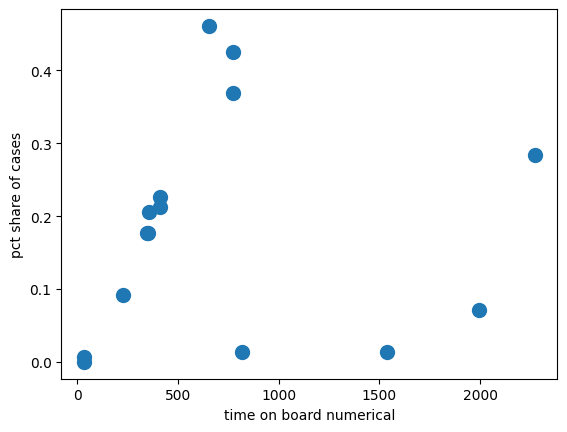

In [61]:
# exclude shelton as an outlier
prb_date[prb_date['Last'] != 'Shelton'].plot.scatter(x = 'time on board numerical', y = 'pct share of cases', s = 100)

## Relationship between voting patterns and participation 

In [70]:
# change back data types to floats
prb_analysis['pct nays'] = prb_analysis['pct nays'].replace('',0.0)
prb_analysis['pct yays'] = prb_analysis['pct yays'].replace('',0.0)

In [72]:
prb_analysis.sort_values('pct nays', ascending=False).head()

,Name,Last,First,Member Expiration,Member Since,Affiliation,Appointed By,Position,County,yays,nays,total cases,pct yays,pct nays,denials/approvals,share of cases,pct share of cases
0,"Bohland, Jared",Bohland,Jared,01/18/2027,2021-05-03,Republican,Governor,Member,Macon,10,50,60,0.166667,0.833333,5.000000,0.425532,0.425532
11,"Tupy, Kenneth",Tupy,Kenneth,01/15/2029,2021-05-03,Republican,Governor,Member,Sangamon,9,43,52,0.173077,0.826923,4.777778,0.368794,0.368794
4,"Grubbs, Jeffrey",Grubbs,Jeffrey,01/20/2025,2022-11-01,Democrat,Governor,Member,Jackson,3,10,13,0.230769,0.769231,3.333333,0.092199,0.092199
6,"Miller, Lee Ann",Miller,Lee Ann,01/18/2027,2021-09-02,Republican,Governor,Member,Gallatin,19,46,65,0.292308,0.707692,2.421053,0.460993,0.460993
5,"Heaton, Rodger",Heaton,Rodger,01/20/2025,2022-05-01,Republican,Governor,Member,Cook,12,20,32,0.375000,0.625000,1.666667,0.226950,0.226950


In [73]:
print(prb_analysis['pct nays'].corr(prb_analysis['pct share of cases']))

0.8106816757220118


In [74]:
print(prb_analysis['pct yays'].corr(prb_analysis['pct share of cases']))

-0.08395412573411254


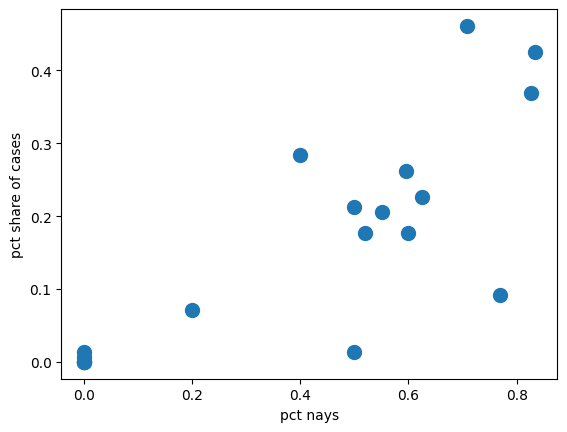

In [75]:
prb_analysis.plot.scatter(x = 'pct nays', y = 'pct share of cases', s = 100);

## Relationship between voting and party affiliation

In [76]:
# missing party affliation for 4 voting members (as of Aug. 21)
party = prb_analysis.groupby('Affiliation')[['yays','nays','total cases']].sum()
party['pct yays'] = party['yays']/(party['yays'] + party['nays'])
party['pct nays'] = party['nays']/(party['yays'] + party['nays'])
party

,yays,nays,total cases,pct yays,pct nays
Affiliation,,,,,
,0,0,0,NaN,NaN
Democrat,89,88,177,0.502825,0.497175
Independent,0,0,0,NaN,NaN
Republican,65,181,246,0.264228,0.735772


In [77]:
# republicans cast more votes than democrats
246/177

1.3898305084745763

In [78]:
246-177

69

In [80]:
# board is split about half and half
prb_analysis.groupby('Affiliation').size().reset_index()

,Affiliation,0
0,,3
1,Democrat,10
2,Independent,1
3,Republican,5


In [81]:
# republicans accounted for 65 percent of all the denial votes but just 40 percent of grant votes
prb_analysis[prb_analysis['Affiliation'] == 'Republican']['nays'].sum()

181

In [82]:
prb_analysis['nays'].sum()

269

In [84]:
181/269

0.6728624535315985

In [85]:
prb_analysis[prb_analysis['Affiliation'] == 'Republican']['yays'].sum()

65

In [86]:
prb_analysis['yays'].sum()

154

In [87]:
65/154

0.42207792207792205

## panel majority party

In [214]:
panel_party_pivot = pd.pivot_table(cases, values='MR #', index='panel_party_majority', columns='decision', aggfunc='count').reset_index()

In [215]:
panel_party_pivot = panel_party_pivot.fillna(0.0)

In [216]:
panel_party_pivot['total'] = panel_party_pivot['denial'] + panel_party_pivot['grant']

In [218]:
panel_party_pivot['pct denial'] = panel_party_pivot['denial']/panel_party_pivot['total']
panel_party_pivot['pct grant'] = panel_party_pivot['grant']/panel_party_pivot['total']

In [219]:
panel_party_pivot

decision,panel_party_majority,denial,grant,total,pct denial,pct grant
0,Majority Democrat,26.0,24.0,50.0,0.520000,0.480000
1,Majority Repbulican,63.0,26.0,89.0,0.707865,0.292135
2,No Majority,0.0,2.0,2.0,0.000000,1.000000
